In [1]:
import torch
import torch2trt
import matplotlib.pyplot as plt
import cv2
import segmentation_models_pytorch as smp

In [2]:
model = torch.load('/models/run10/weights.pt')
model = model.cuda().eval()

In [3]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
encoder.features.0.0.weight 	 torch.Size([32, 3, 3, 3])
encoder.features.0.1.weight 	 torch.Size([32])
encoder.features.0.1.bias 	 torch.Size([32])
encoder.features.0.1.running_mean 	 torch.Size([32])
encoder.features.0.1.running_var 	 torch.Size([32])
encoder.features.0.1.num_batches_tracked 	 torch.Size([])
encoder.features.1.conv.0.0.weight 	 torch.Size([32, 1, 3, 3])
encoder.features.1.conv.0.1.weight 	 torch.Size([32])
encoder.features.1.conv.0.1.bias 	 torch.Size([32])
encoder.features.1.conv.0.1.running_mean 	 torch.Size([32])
encoder.features.1.conv.0.1.running_var 	 torch.Size([32])
encoder.features.1.conv.0.1.num_batches_tracked 	 torch.Size([])
encoder.features.1.conv.1.weight 	 torch.Size([16, 32, 1, 1])
encoder.features.1.conv.2.weight 	 torch.Size([16])
encoder.features.1.conv.2.bias 	 torch.Size([16])
encoder.features.1.conv.2.running_mean 	 torch.Size([16])
encoder.features.1.conv.2.running_var 	 torch.Size([16])
encoder.features.1.conv.2.num_batches

In [4]:

class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super(ModelWrapper, self).__init__()
        self.model = model
    def forward(self, x):
        return self.model(x)

model_w = ModelWrapper(model)
data = torch.ones((1,3,320,640)).cuda()

In [5]:
model_trt = torch2trt.torch2trt(model_w,[data],fp16_mode=True, max_batch_size=1)

In [6]:
torch.save(model_trt.state_dict(), '/models/run10/state_dict_trt.pt')

In [58]:
ino = 699
# Read  a sample image and mask from the data-set
img = cv2.imread(f'/models/train_data/Images/{ino:03d}.jpg').transpose(2,0,1).reshape(1,3,320,640)
mask = cv2.imread(f'/models/train_data/Masks/{ino:03d}_mask.png')
input = torch.from_numpy(img).type(torch.cuda.FloatTensor)/255

with torch.no_grad():
    output = model(input)




In [59]:
img.shape

(1, 3, 320, 640)

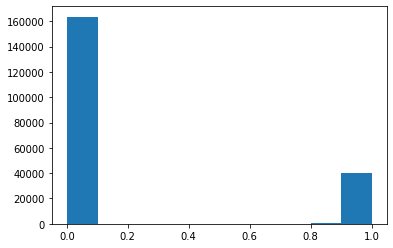

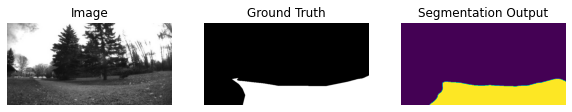

In [61]:

# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
plt.hist(output.data.cpu().numpy().flatten())


# Plot the input image, ground truth and the predicted output
plt.figure(figsize=(10,10));
plt.subplot(131);
plt.imshow(img[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(mask);
plt.title('Ground Truth')
plt.axis('off');
plt.subplot(133);
plt.imshow(output.cpu().detach().numpy()[0][0]>0.4);
plt.title('Segmentation Output')
plt.axis('off');

In [50]:
# %%
output_trt = model_trt(input)


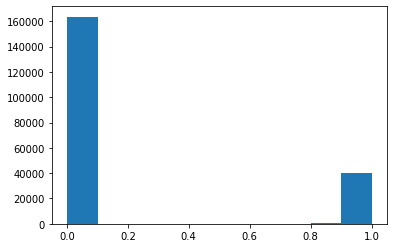

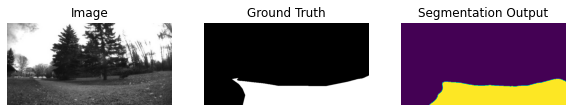

In [62]:
# %%
# Plot histogram of the prediction to find a suitable threshold. From the histogram a 0.1 looks like a good choice.
plt.hist(output_trt.data.cpu().numpy().flatten())


# %%
# Plot the input image, ground truth and the predicted output
plt.figure(figsize=(10,10));
plt.subplot(131);
plt.imshow(img[0,...].transpose(1,2,0));
plt.title('Image')
plt.axis('off');
plt.subplot(132);
plt.imshow(mask);
plt.title('Ground Truth')
plt.axis('off');
plt.subplot(133);
plt.imshow(output_trt.cpu()[0][0]>0.4);
plt.title('Segmentation Output')
plt.axis('off');
